## 1.Environment Setup

In [ ]:
import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.preprocessing import PowerTransformer


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier



from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from scipy.stats import randint, uniform

SEED = 42
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

: 

## 2.Data Processing

In [ ]:
# Cài đặt thư viện
# pip install kagglehub[pandas-datasets]

import kagglehub
from kagglehub import KaggleDatasetAdapter

# Tên dataset Kaggle
dataset = "johnsmith88/heart-disease-dataset"

# Ví dụ dataset này có file chính: heart.csv
file_path = "heart.csv"

# Load dataset bằng pandas
df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    dataset,
    file_path,
)

print("5 dòng đầu tiên:")
print(df.head())


Using Colab cache for faster access to the 'heart-disease-dataset' dataset.
5 dòng đầu tiên:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0  


In [ ]:
raw = df.copy()

# Tên cột rút gọn theo chuẩn thường dùng:
# age in years
# sex (1 = male; 0 = female)
# chest pain type (4 values)                                  -> cp
# resting blood pressure                                      -> trestbps (in mm Hg on admission to the hospital)
# serum cholestoral in mg/dl                                  -> chol (serum cholestoral in mg/dl)
# fasting blood sugar > 120 mg/dl                             -> fbs (1 = true; 0 = false)
# resting electrocardiographic results                        -> restecg
# maximum heart rate achieved                                 -> thalach
# exercise induced angina                                     -> exang (1 = yes; 0 = no)
# oldpeak                                                     -> oldpeak
# slope                                                       -> slope
# number of major vessels (0-3) colored by flourosopy         -> ca
# thal: 0=normal,1=fixed,2=reversable                         -> thal
# target (nhị phân: bệnh hay không)                           -> target
COLUMNS = [
    'age','sex','cp','trestbps','chol','fbs','restecg',
    'thalach','exang','oldpeak','slope','ca','thal','target'
]

if raw.shape[1] != len(COLUMNS):
    raise ValueError(f"Số cột bất thường: {raw.shape[1]}, kỳ vọng {len(COLUMNS)}.")
# Nếu tên cột không khớp, ép về chuẩn:
if list(raw.columns) != COLUMNS:
    raw.columns = COLUMNS


numeric_cols = ['age','trestbps','chol','thalach','oldpeak']
categorical_cols = ['sex','cp','fbs','restecg','exang','slope','ca','thal']

K_features = 10

# Đọc dữ liệu gốc không có header
raw = raw.replace('?', np.nan)

# Gắn tên cột
raw.columns = COLUMNS

# Ép kiểu số cho các cột thường có ký tự '?'
for c in ['age','trestbps','chol','thalach','oldpeak','ca','thal']:
    raw[c] = pd.to_numeric(raw[c], errors='coerce')

# Chuyển 'target' về nhị phân: >0 là có bệnh (1), 0 là không bệnh (0)
raw['target'] = (raw['target'] > 0).astype(int)

print("Shape:", raw.shape)
display(raw.head())
display(raw.isna().sum())

Shape: (1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


## 3.Data Post-processing

In [4]:
TARGET = 'target'
raw_feature_cols = [c for c in raw.columns if c != TARGET]

X_all = raw[raw_feature_cols]
y_all = raw[TARGET]

X_train, X_temp, y_train, y_temp = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

cat_proc = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', MinMaxScaler())
])
num_proc = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocess = ColumnTransformer([
    ('num', num_proc, numeric_cols),
    ('cat', cat_proc, categorical_cols),
])
raw_pipeline = Pipeline([
    ('preprocess', preprocess),
])

X_raw_train = raw_pipeline.fit_transform(X_train, y_train)
X_raw_val = raw_pipeline.transform(X_val)
X_raw_test = raw_pipeline.transform(X_test)


## 4.Kiểm tra phân phối dữ liệu tập train



### 4.1 Dữ liệu dạng số
numeric_cols = 'age', 'trestbps', 'chol', 'thalach', 'oldpeak'

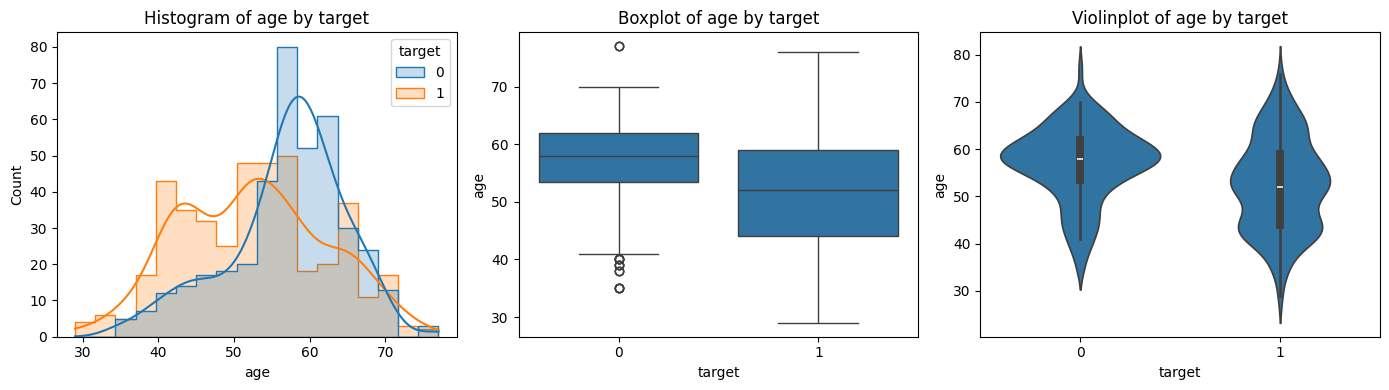

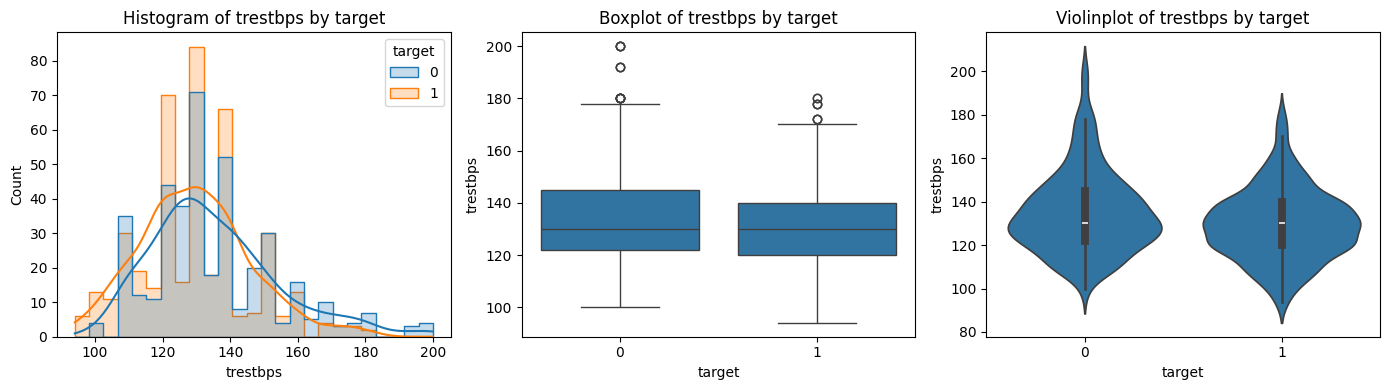

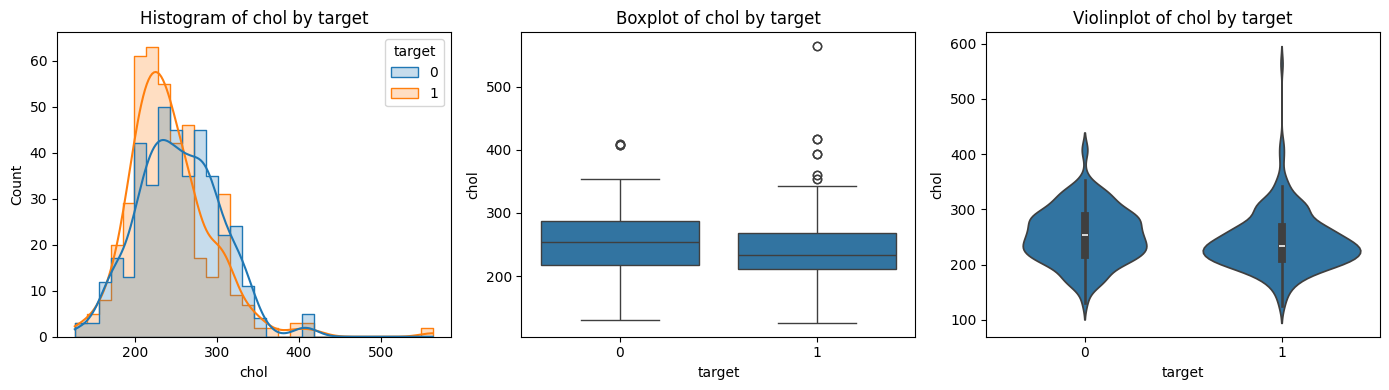

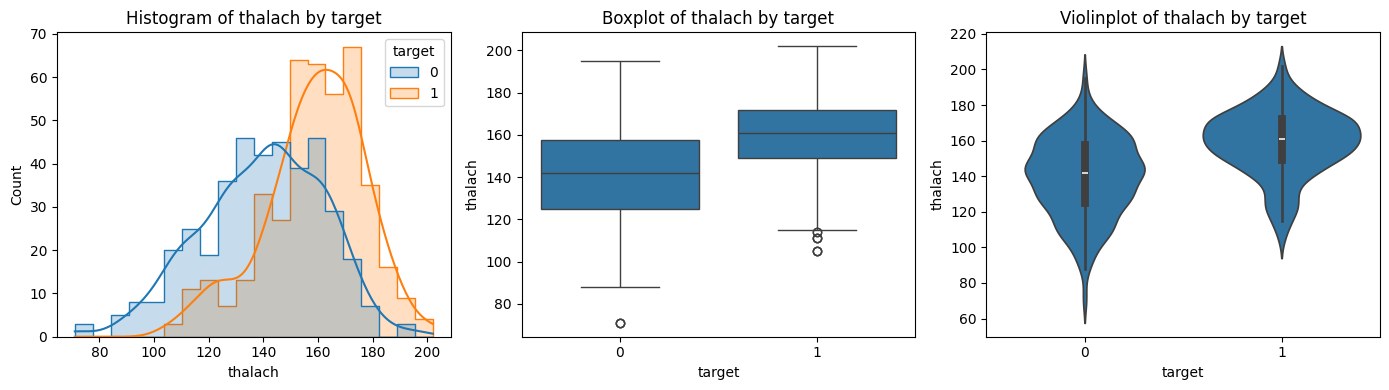

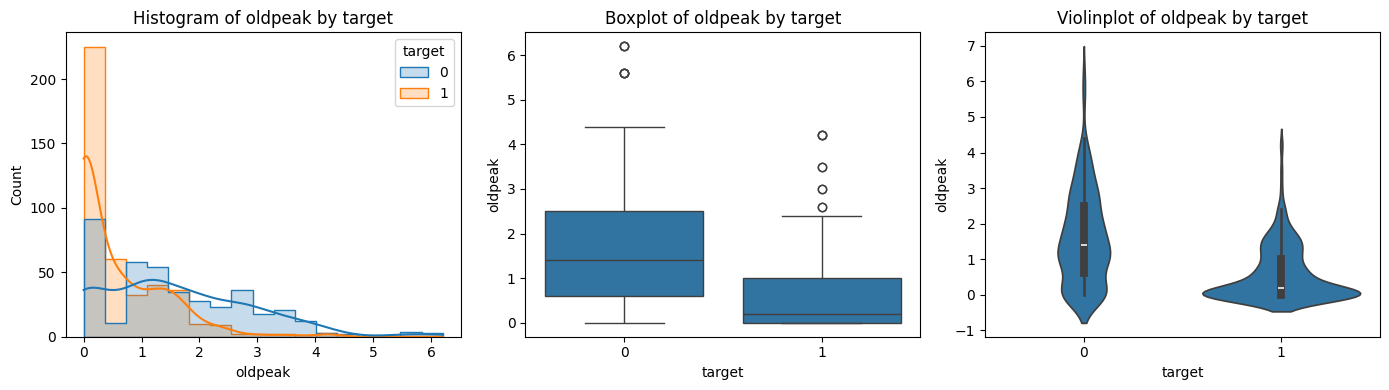

In [5]:
# Gộp X_train và y_train để tiện vẽ
eda_df = X_train.copy()
eda_df[TARGET] = y_train

# Các cột numeric muốn kiểm tra
cols_to_plot =  numeric_cols  # ['age','trestbps','chol','thalach','oldpeak']

for col in cols_to_plot:
    plt.figure(figsize=(14,4))

    # Histplot
    plt.subplot(1,3,1)
    sns.histplot(data=eda_df, x=col, hue=TARGET, kde=True, element="step")
    plt.title(f"Histogram of {col} by {TARGET}")

    # Boxplot
    plt.subplot(1,3,2)
    sns.boxplot(data=eda_df, x=TARGET, y=col)
    plt.title(f"Boxplot of {col} by {TARGET}")

    # Violinplot
    plt.subplot(1,3,3)
    sns.violinplot(data=eda_df, x=TARGET, y=col)
    plt.title(f"Violinplot of {col} by {TARGET}")

    plt.tight_layout()
    plt.show()


Độ lệch (skewness) của các biến numeric:
age        : skew = -0.272 → Gần chuẩn (symmetric)
trestbps   : skew = 0.766 → Lệch phải (right-skewed)
chol       : skew = 0.940 → Lệch phải (right-skewed)
thalach    : skew = -0.492 → Gần chuẩn (symmetric)
oldpeak    : skew = 1.265 → Lệch phải (right-skewed)


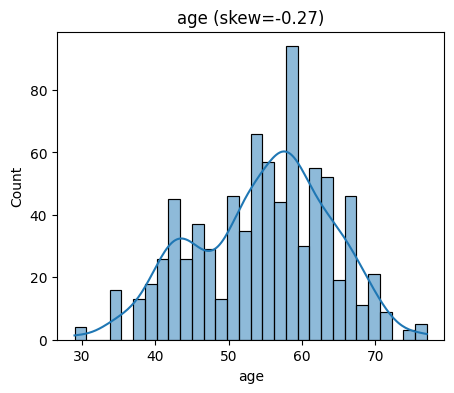

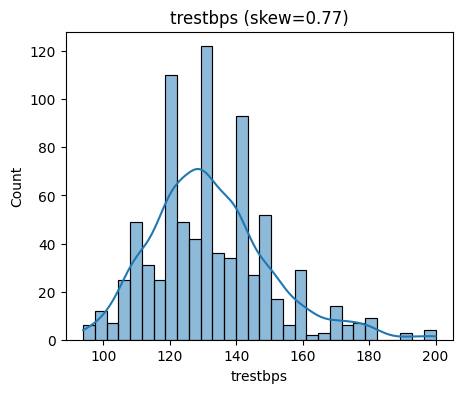

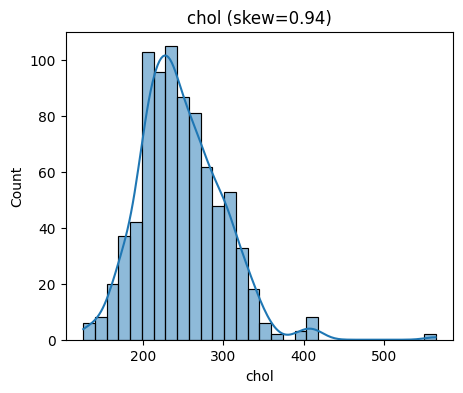

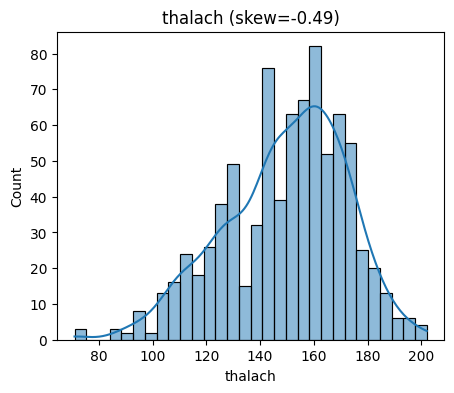

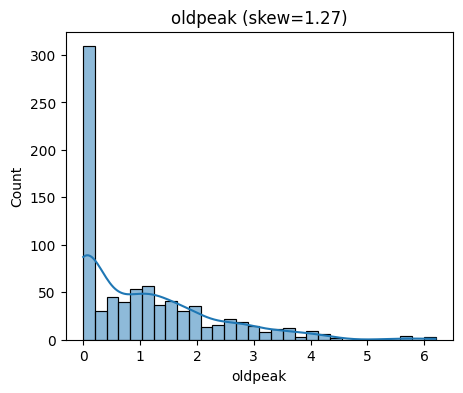


Ví dụ sau khi rời rạc hóa (4 bins):


,age_bin,trestbps_bin,chol_bin,thalach_bin,oldpeak_bin
4,3,2,3,0,2
688,1,3,3,0,2
477,2,1,1,1,0
336,2,3,0,3,0
960,1,2,0,3,0


In [6]:
# Tính skewness (Độ lệch) cho từng biến numeric
skew_results = {}
for col in cols_to_plot:
    skew_val = X_train[col].skew()  # hệ số skewness
    if skew_val > 0.5:
        skew_type = "Lệch phải (right-skewed)"
    elif skew_val < -0.5:
        skew_type = "Lệch trái (left-skewed)"
    else:
        skew_type = "Gần chuẩn (symmetric)"
    skew_results[col] = (skew_val, skew_type)

# Hiển thị kết quả
print("Độ lệch (skewness) của các biến numeric:")
for col, (val, typ) in skew_results.items():
    print(f"{col:10s} : skew = {val:.3f} → {typ}")

# Vẽ histogram để trực quan
for col in numeric_cols:
    plt.figure(figsize=(5,4))
    sns.histplot(X_train[col], kde=True, bins=30)
    plt.title(f"{col} (skew={X_train[col].skew():.2f})")
    plt.show()

# Ví dụ rời rạc hóa (binning) cho một số biến lệch nhiều
# Dùng qcut để chia thành 4 nhóm theo phân vị
binned_df = X_train.copy()
for col in numeric_cols:
    binned_df[f"{col}_bin"] = pd.qcut(X_train[col], q=4, labels=False, duplicates="drop")

print("\nVí dụ sau khi rời rạc hóa (4 bins):")
display(binned_df[[f"{c}_bin" for c in numeric_cols]].head())

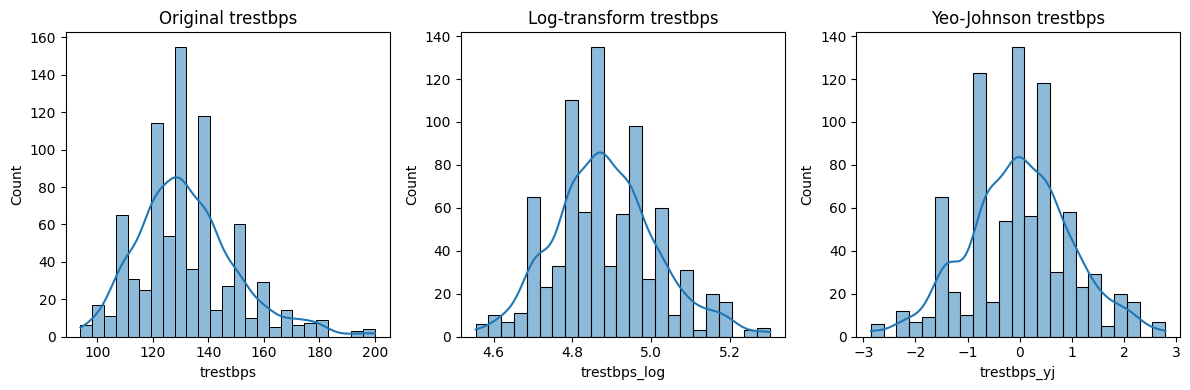

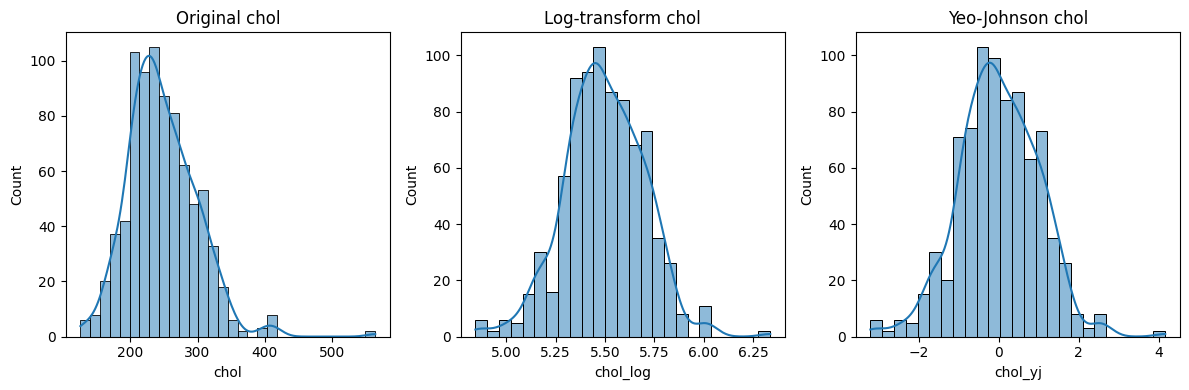

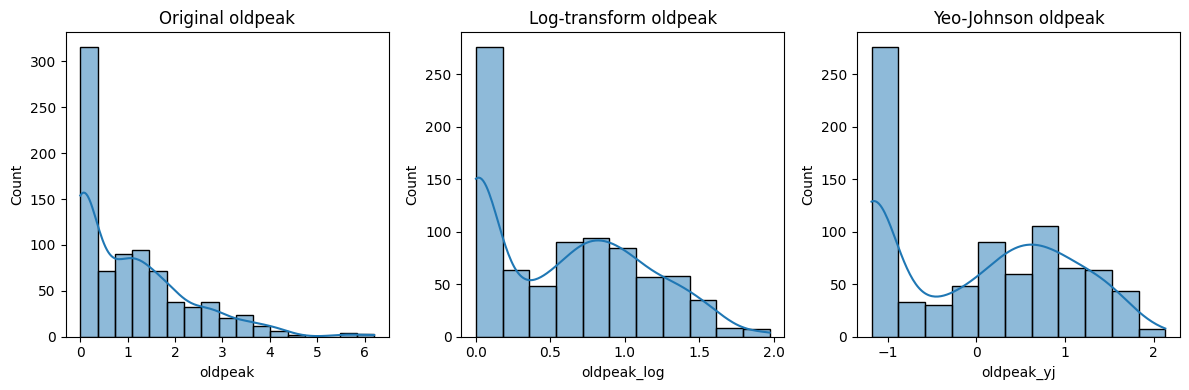

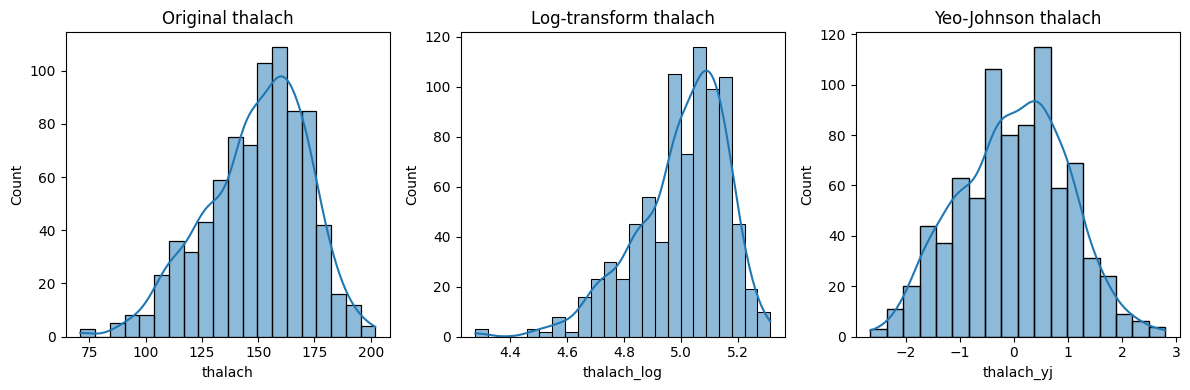

In [7]:
# Các cột muốn kiểm tra (lấy từ numeric_cols để đồng bộ biến đã có)
eda_cols = [c for c in ['trestbps','chol','oldpeak','thalach'] if c in numeric_cols]

# Lấy dữ liệu train cho các cột này
eda_df = X_train[eda_cols].copy()

# Log-transform (log1p an toàn với 0)
for col in eda_cols:
    eda_df[f"{col}_log"] = np.log1p(eda_df[col])

# Yeo-Johnson transform
pt = PowerTransformer(method='yeo-johnson')
eda_df[[f"{col}_yj" for col in eda_cols]] = pt.fit_transform(eda_df[eda_cols])

# Vẽ histplot so sánh trước/sau biến đổi
for col in eda_cols:
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    sns.histplot(eda_df[col], kde=True)
    plt.title(f"Original {col}")

    plt.subplot(1,3,2)
    sns.histplot(eda_df[f"{col}_log"], kde=True)
    plt.title(f"Log-transform {col}")

    plt.subplot(1,3,3)
    sns.histplot(eda_df[f"{col}_yj"], kde=True)
    plt.title(f"Yeo-Johnson {col}")

    plt.tight_layout()
    plt.show()


**⚠️ Nên xử lý thế nào?**

Nếu dùng **mô hình tuyến tính hoặc SVM/KNN** → nên biến đổi để phân phối gần chuẩn hơn:
*   trestbps, chol, oldpeak → log hoặc yeo-johnson.
*   thalach → yeo-johnson (vì lệch trái).

Nếu dùng **tree-based models (DecisionTree, RandomForest, XGBoost, LightGBM)** → không cần ép phân phối chuẩn, vì cây chỉ chia ngưỡng. Có thể:
*   Giữ nguyên giá trị numeric.
*   Hoặc rời rạc hóa (binning) để tăng tính giải thích (ví dụ phân loại cholesterol thành nhóm: thấp, vừa, cao).

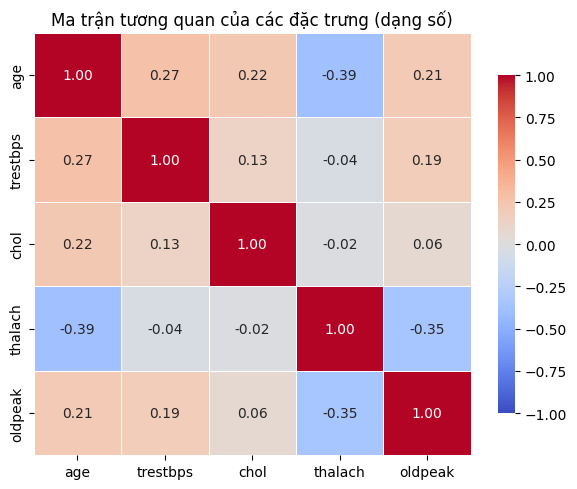

In [ ]:
plt.figure(figsize=(6, 5))
corr_matrix = raw[numeric_cols].corr(method='pearson')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f",
            vmin=-1, vmax=1, center=0, linewidths=.5, cbar_kws={"shrink": .8})
plt.title("Ma trận tương quan của các đặc trưng (dạng số)")
plt.tight_layout()
plt.savefig("correlation_matrix.pdf", bbox_inches="tight")
plt.show()

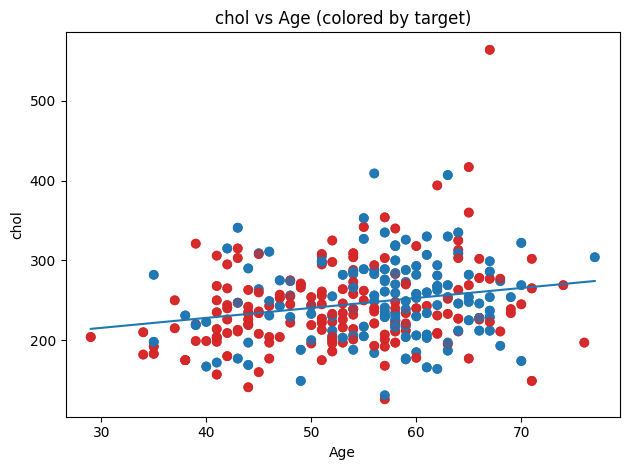

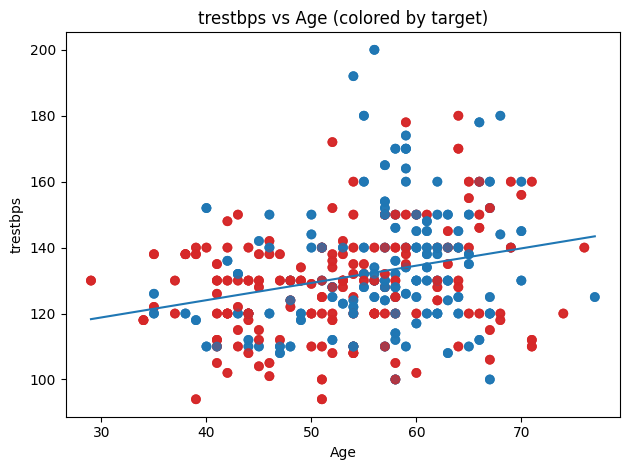

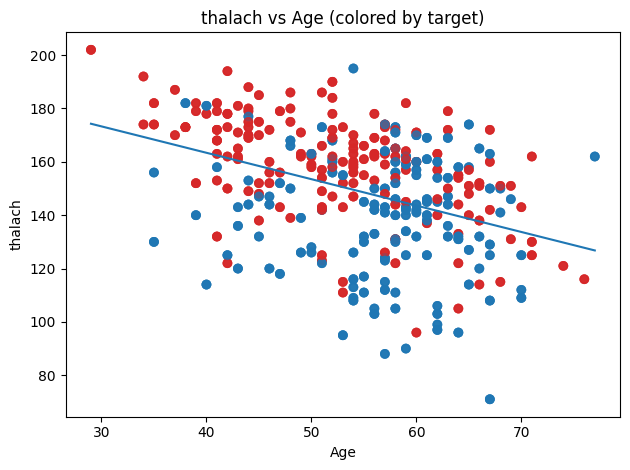

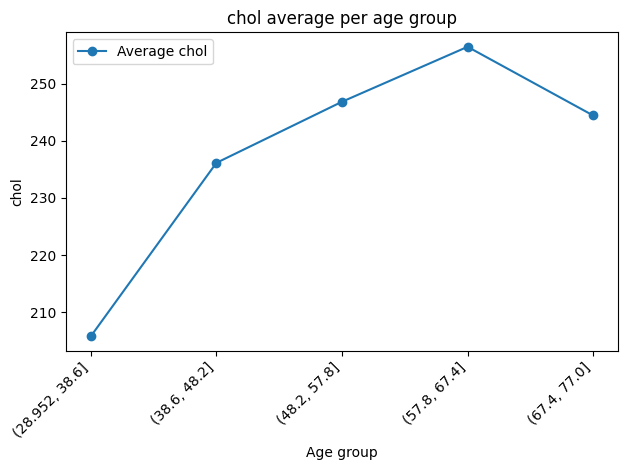

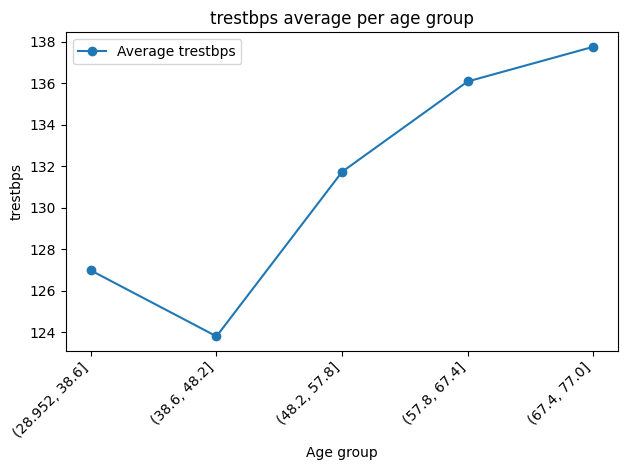

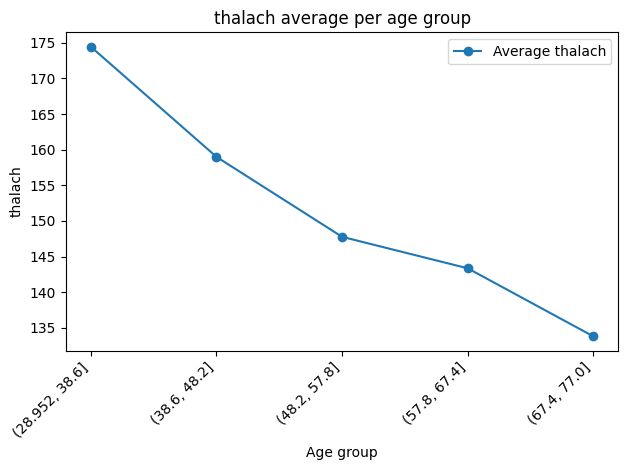

In [8]:
X = raw.drop(columns=[TARGET])
y = raw[TARGET].astype(int)

# Màu theo nhãn: 0 = xanh, 1 = đỏ
colors = np.where(y.values == 0, 'tab:blue', 'tab:red')

# Chỉ lấy các metric có trong dữ liệu
want_metrics = ['chol', 'trestbps', 'thalach']
metrics = [c for c in want_metrics if c in X.columns]

def scatter_with_regression(xs, ys, xlab, ylab, title):
    m = xs.notna() & ys.notna()
    x = xs[m].to_numpy()
    yy = ys[m].to_numpy()

    plt.figure()
    plt.scatter(x, yy, c=colors[m.values], alpha=0.7)

    if len(x) > 1:
        k, b = np.polyfit(x, yy, 1)
        xline = np.linspace(np.nanmin(x), np.nanmax(x), 100)
        plt.plot(xline, k * xline + b)

    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Scatter mỗi metric theo tuổi, tô màu theo target và thêm đường hồi quy
if 'age' in X.columns and metrics:
    for mtr in metrics:
        scatter_with_regression(
            X['age'], X[mtr],
            xlab='Age', ylab=mtr,
            title=f'{mtr} vs Age (colored by target)'
        )

# Trung bình mỗi metric theo nhóm tuổi (5 bins)
if 'age' in X.columns and metrics:
    age_bins = pd.cut(X['age'], bins=5)
    for mtr in metrics:
        plt.figure()
        avg_vals = X.groupby(age_bins, observed=True)[mtr].mean()
        plt.plot(range(len(avg_vals)), avg_vals, marker='o', label=f'Average {mtr}')
        plt.xticks(range(len(avg_vals)), [str(idx) for idx in avg_vals.index], rotation=45, ha='right')
        plt.xlabel('Age group')
        plt.ylabel(mtr)
        plt.title(f'{mtr} average per age group')
        plt.legend()
        plt.tight_layout()
        plt.show()

### 4.2 Dữ liệu phân loại
categorical_cols ='sex','cp','fbs','restecg','exang','slope','ca','thal'


--- sex ---
Tần suất (tỉ lệ):
sex
1    0.69561
0    0.30439
Name: proportion, dtype: float64

Phân bố theo target (tỉ lệ trong từng nhóm):
target         0         1
sex                       
0       0.275641  0.724359
1       0.579243  0.420757


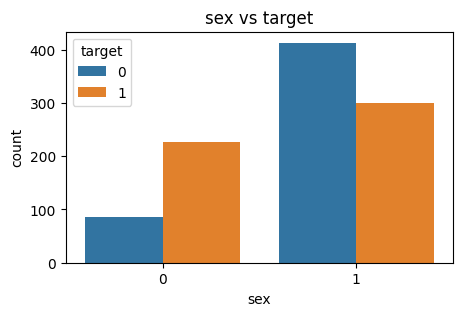


--- cp ---
Tần suất (tỉ lệ):
cp
0    0.484878
2    0.277073
1    0.162927
3    0.075122
Name: proportion, dtype: float64

Phân bố theo target (tỉ lệ trong từng nhóm):
target         0         1
cp                        
0       0.754527  0.245473
1       0.197605  0.802395
2       0.228873  0.771127
3       0.337662  0.662338


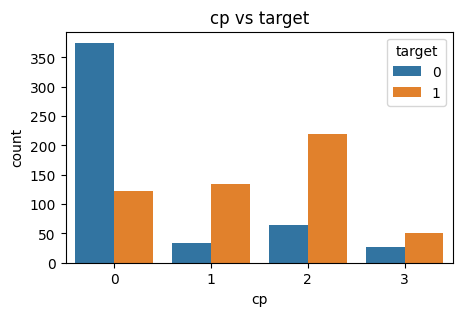


--- fbs ---
Tần suất (tỉ lệ):
fbs
0    0.850732
1    0.149268
Name: proportion, dtype: float64

Phân bố theo target (tỉ lệ trong từng nhóm):
target         0         1
fbs                       
0       0.478211  0.521789
1       0.535948  0.464052


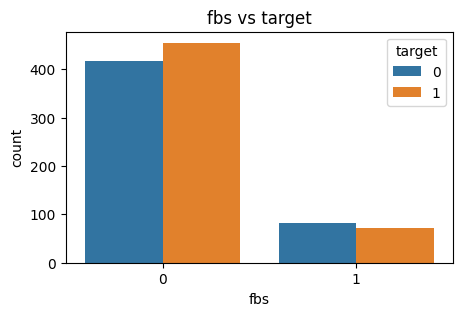


--- restecg ---
Tần suất (tỉ lệ):
restecg
1    0.500488
0    0.484878
2    0.014634
Name: proportion, dtype: float64

Phân bố theo target (tỉ lệ trong từng nhóm):
target          0         1
restecg                    
0        0.569416  0.430584
1        0.397661  0.602339
2        0.800000  0.200000


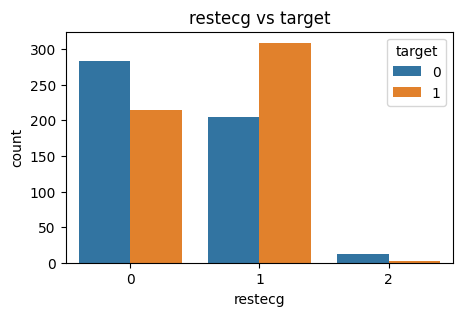


--- exang ---
Tần suất (tỉ lệ):
exang
0    0.663415
1    0.336585
Name: proportion, dtype: float64

Phân bố theo target (tỉ lệ trong từng nhóm):
target         0         1
exang                     
0       0.330882  0.669118
1       0.794203  0.205797


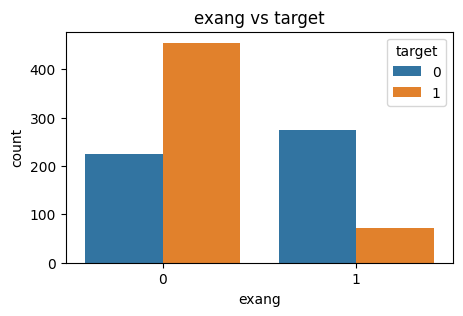


--- slope ---
Tần suất (tỉ lệ):
slope
1    0.470244
2    0.457561
0    0.072195
Name: proportion, dtype: float64

Phân bố theo target (tỉ lệ trong từng nhóm):
target         0         1
slope                     
0       0.621622  0.378378
1       0.672199  0.327801
2       0.275053  0.724947


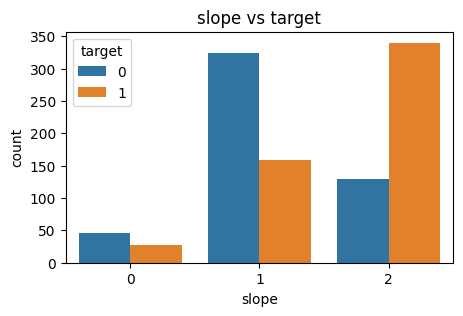


--- ca ---
Tần suất (tỉ lệ):
ca
0    0.563902
1    0.220488
2    0.130732
3    0.067317
4    0.017561
Name: proportion, dtype: float64

Phân bố theo target (tỉ lệ trong từng nhóm):
target         0         1
ca                        
0       0.282007  0.717993
1       0.707965  0.292035
2       0.843284  0.156716
3       0.869565  0.130435
4       0.166667  0.833333


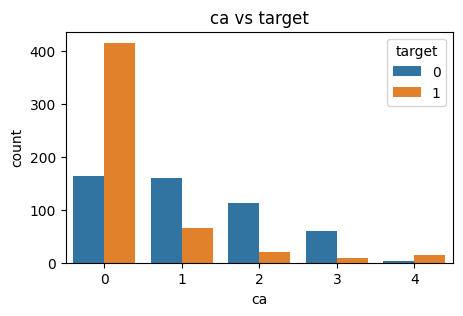


--- thal ---
Tần suất (tỉ lệ):
thal
2    0.530732
3    0.400000
1    0.062439
0    0.006829
Name: proportion, dtype: float64
⚠️ Rare categories (<1%): [0]

Phân bố theo target (tỉ lệ trong từng nhóm):
target         0         1
thal                      
0       0.571429  0.428571
1       0.671875  0.328125
2       0.242647  0.757353
3       0.780488  0.219512


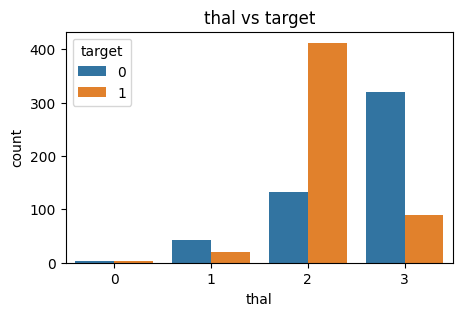

In [9]:
def check_categorical_issues(df, categorical_cols, target_col=None, rare_thresh=0.01):
    """
    Đánh giá các biến phân loại:
      - Tần suất phân bố
      - Thiếu dữ liệu
      - Rare categories (chiếm < rare_thresh)
      - Phân bố theo target (nếu có target_col)
    """
    results = {}
    n = len(df)

    for col in categorical_cols:
        if col == target_col:  # bỏ qua target
            continue

        print(f"\n--- {col} ---")

        # Đếm tần suất (bao gồm NaN)
        vc = df[col].value_counts(dropna=False, normalize=True)
        print("Tần suất (tỉ lệ):")
        print(vc)

        # Kiểm tra missing
        missing_rate = df[col].isna().mean()
        if missing_rate > 0:
            print(f"⚠️ Thiếu dữ liệu: {missing_rate:.2%}")

        # Kiểm tra rare categories
        rare_cats = vc[vc < rare_thresh].index.tolist()
        if rare_cats:
            print(f"⚠️ Rare categories (<{rare_thresh*100:.0f}%): {rare_cats}")

        # Nếu có target thì kiểm tra phân bố theo target
        if target_col is not None and target_col in df.columns:
            ct = pd.crosstab(df[col], df[target_col], normalize='index')
            print("\nPhân bố theo target (tỉ lệ trong từng nhóm):")
            print(ct)

            plt.figure(figsize=(5,3))
            sns.countplot(data=df, x=col, hue=target_col)
            plt.title(f"{col} vs {target_col}")
            plt.show()

        results[col] = {
            "missing_rate": missing_rate,
            "rare_cats": rare_cats,
            "n_unique": df[col].nunique(dropna=False)
        }
    return results

cat_issues = check_categorical_issues(raw, categorical_cols, target_col='target')

**⚠️ Nên xử lý thế nào?**

*   **Thiếu dữ liệu (NaN) ở biến phân loại**: thay vì “đoán” giá trị, nên giữ riêng một nhãn “Missing” để tránh đưa bias (đặc biệt hữu ích cho tree-based models).

*   **Nhóm hiếm (rare): nếu có nhóm chiếm <1% (ngoại trừ “Missing”):** gộp vào "Other" để ổn định mô hình và tránh one-hot quá thưa.

##5.Processed Dataset (Raw Dataset)

In [10]:
preprocessed_feature_names = []
for name, transformer, columns in preprocess.transformers_:
    if hasattr(transformer, 'get_feature_names_out'):
        preprocessed_feature_names.extend(transformer.get_feature_names_out(columns))
    else:
        preprocessed_feature_names.extend(columns)

X_raw_train_df = pd.DataFrame(
    X_raw_train, columns=preprocessed_feature_names, index=X_train.index)
X_raw_val_df = pd.DataFrame(
    X_raw_val, columns=preprocessed_feature_names, index=X_val.index)
X_raw_test_df = pd.DataFrame(
    X_raw_test, columns=preprocessed_feature_names, index=X_test.index)

out_dir = Path('splits'); out_dir.mkdir(parents=True, exist_ok=True)
pd.concat([X_raw_train_df, y_train.rename(TARGET)],
          axis=1).to_csv(out_dir / 'raw_train.csv', index=False)
pd.concat([X_raw_val_df, y_val.rename(TARGET)],
          axis=1).to_csv(out_dir / 'raw_val.csv', index=False)
pd.concat([X_raw_test_df, y_test.rename(TARGET)],
          axis=1).to_csv(out_dir / 'raw_test.csv', index=False)

display(X_raw_train_df)


,age,trestbps,chol,thalach,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal
4,0.811626,0.314729,0.895791,-1.921155,0.696525,0.0,0.000000,1.0,0.5,0.0,0.5,0.75,0.666667
688,0.152247,3.767643,0.779115,-0.725362,2.475810,0.0,0.000000,1.0,0.0,1.0,0.0,0.50,1.000000
477,0.262144,-0.242193,-0.368191,0.027545,-0.574393,1.0,0.666667,0.0,0.0,0.0,0.5,0.25,1.000000
336,0.262144,0.983035,-2.371116,1.046184,-0.743849,1.0,0.666667,1.0,0.5,0.0,1.0,0.25,1.000000
960,-0.287339,0.203344,-1.009905,0.869030,-0.828577,0.0,0.666667,0.0,0.0,0.0,0.5,0.00,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
882,0.262144,-0.130809,-2.273886,-1.522557,0.103430,1.0,0.000000,0.0,0.5,1.0,0.5,0.25,1.000000
367,-0.726926,-1.244652,-0.368191,0.824741,-0.066026,1.0,0.333333,0.0,0.5,0.0,0.0,0.00,1.000000
393,0.811626,1.539956,-1.632172,-0.193898,4.339823,0.0,0.000000,0.0,0.0,0.0,0.0,0.75,1.000000
777,-0.177443,-0.520654,0.662440,-2.408330,0.781253,1.0,0.000000,0.0,0.5,1.0,0.5,0.50,1.000000


##6.Decision Tree Feature Selection

In [11]:
dt_feature_selection_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('feature_select', SelectFromModel(
        estimator=DecisionTreeClassifier(
            random_state=42,
            class_weight='balanced'
        ),
        max_features=K_features,   # chọn đúng K_features
        threshold=None             # top-K theo importance
    ))
])

In [12]:
dt_feature_selection_pipeline.fit(
    X_train, y_train
)
feature_importance_series = pd.Series(
    dt_feature_selection_pipeline.named_steps['feature_select']
    .estimator_.feature_importances_,
    index=preprocessed_feature_names
)
sorted_feature_importances = feature_importance_series.sort_values(ascending=False)

print("Sorted Feature Importances:")
display(sorted_feature_importances)

Sorted Feature Importances:


,0
cp,0.290183
ca,0.135654
chol,0.124859
age,0.114588
thal,0.078420
thalach,0.044428
oldpeak,0.042591
trestbps,0.042500
slope,0.041514
sex,0.036595


In [14]:
selected_features = np.array(preprocessed_feature_names)[
    dt_feature_selection_pipeline.named_steps['feature_select'].get_support()
]
print(f"Top {K_features} selected features:")
print(selected_features)

Top 10 selected features:
['age' 'chol' 'cp' 'ca' 'thal']


In [15]:
X_dt_train =  pd.DataFrame(
    dt_feature_selection_pipeline.transform(X_train),
    columns=selected_features,
    index=X_train.index
)

X_dt_val = pd.DataFrame(
    dt_feature_selection_pipeline.transform(X_val),
    columns=selected_features,
    index=X_val.index
)

X_dt_test = pd.DataFrame(
    dt_feature_selection_pipeline.transform(X_test),
    columns=selected_features,
    index=X_test.index
)

print("Head of X_dt_train:")
display(X_dt_train.head())
print("\nShape of X_dt_train:", X_dt_train.shape)

Head of X_dt_train:


,age,chol,cp,ca,thal
4,0.811626,0.895791,0.000000,0.75,0.666667
688,0.152247,0.779115,0.000000,0.50,1.000000
477,0.262144,-0.368191,0.666667,0.25,1.000000
336,0.262144,-2.371116,0.666667,0.25,1.000000
960,-0.287339,-1.009905,0.666667,0.00,0.666667



Shape of X_dt_train: (820, 5)


In [16]:
pd.concat([X_dt_train, y_train.rename(TARGET)],
          axis=1).to_csv(out_dir / 'dt_train.csv', index=False)
pd.concat([X_dt_val, y_val.rename(TARGET)],
          axis=1).to_csv(out_dir / 'dt_val.csv', index=False)
pd.concat([X_dt_test, y_test.rename(TARGET)],
          axis=1).to_csv(out_dir / 'dt_test.csv', index=False)

print(f"Saved RAW_DT splits. K (RAW_DT features) = {K_features}")
X_dt_train

Saved RAW_DT splits. K (RAW_DT features) = 10


,age,chol,cp,ca,thal
4,0.811626,0.895791,0.000000,0.75,0.666667
688,0.152247,0.779115,0.000000,0.50,1.000000
477,0.262144,-0.368191,0.666667,0.25,1.000000
336,0.262144,-2.371116,0.666667,0.25,1.000000
960,-0.287339,-1.009905,0.666667,0.00,0.666667
...,...,...,...,...,...
882,0.262144,-2.273886,0.000000,0.25,1.000000
367,-0.726926,-0.368191,0.333333,0.00,1.000000
393,0.811626,-1.632172,0.000000,0.75,1.000000
777,-0.177443,0.662440,0.000000,0.50,1.000000



##7.Feature Engineering

In [17]:
# 1) Hàm tạo feature mới
def add_new_features_func(df):
    df = df.copy()
    if {'chol','age'} <= set(df.columns):
        df['chol_per_age'] = df['chol']/df['age']
    if {'trestbps','age'} <= set(df.columns):
        df['bps_per_age'] = df['trestbps']/df['age']
    if {'thalach','age'} <= set(df.columns):
        df['hr_ratio'] = df['thalach']/df['age']
    if 'age' in df.columns:
        df['age_bin'] = pd.cut(df['age'], bins=5, labels=False).astype('category')
    return df

# 2) Khai báo danh sách cột
numeric_cols = ['age','trestbps','chol','thalach','oldpeak']
categorical_cols = ['sex','cp','fbs','restecg','exang','slope','ca','thal']
gen_num = ['chol_per_age','bps_per_age','hr_ratio']
gen_cat = ['age_bin']
all_nums = numeric_cols + gen_num
all_cats = categorical_cols + gen_cat

# 3) Transformer tạo feature (thêm set_output no-op)
class AddNewFeaturesTransformer(BaseEstimator, TransformerMixin):
    def set_output(self, *, transform=None):
        self._transform_output = transform
        return self
    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        self.columns_ = X.columns.tolist()
        self.new_features_ = []
        if {'chol','age'} <= set(X.columns):     self.new_features_.append('chol_per_age')
        if {'trestbps','age'} <= set(X.columns): self.new_features_.append('bps_per_age')
        if {'thalach','age'} <= set(X.columns):  self.new_features_.append('hr_ratio')
        if 'age' in X.columns:                   self.new_features_.append('age_bin')
        return self
    def transform(self, X):
        X = pd.DataFrame(X).copy()
        X_new = add_new_features_func(X)
        expected = list(self.columns_) + [c for c in self.new_features_ if c in X_new.columns]
        return X_new[expected]
    def get_feature_names_out(self, input_features=None):
        return list(self.columns_) + list(getattr(self, 'new_features_', []))

# 4) Pipelines & ColumnTransformer
num_proc = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('sc',  StandardScaler())
])
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
cat_proc = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('ohe', ohe)
])

pre = ColumnTransformer([
    ('num', num_proc, all_nums),
    ('cat', cat_proc, all_cats),
], verbose_feature_names_out=False).set_output(transform='pandas')

fe_pre = Pipeline([
    ('add', AddNewFeaturesTransformer()),
    ('pre', pre),
]).set_output(transform='pandas')


#Chạy pipeline FE + tiền xử lý
Xt_tr = fe_pre.fit_transform(X_train, y_train)
Xt_va = fe_pre.transform(X_val)
Xt_te = fe_pre.transform(X_test)

#Loại cột “không có biến thiên” (zero-variance) dựa trên train
nz_cols = Xt_tr.columns[Xt_tr.nunique(dropna=False) > 1]
Xt_tr = Xt_tr[nz_cols]
Xt_va = Xt_va[nz_cols]
Xt_te = Xt_te[nz_cols]

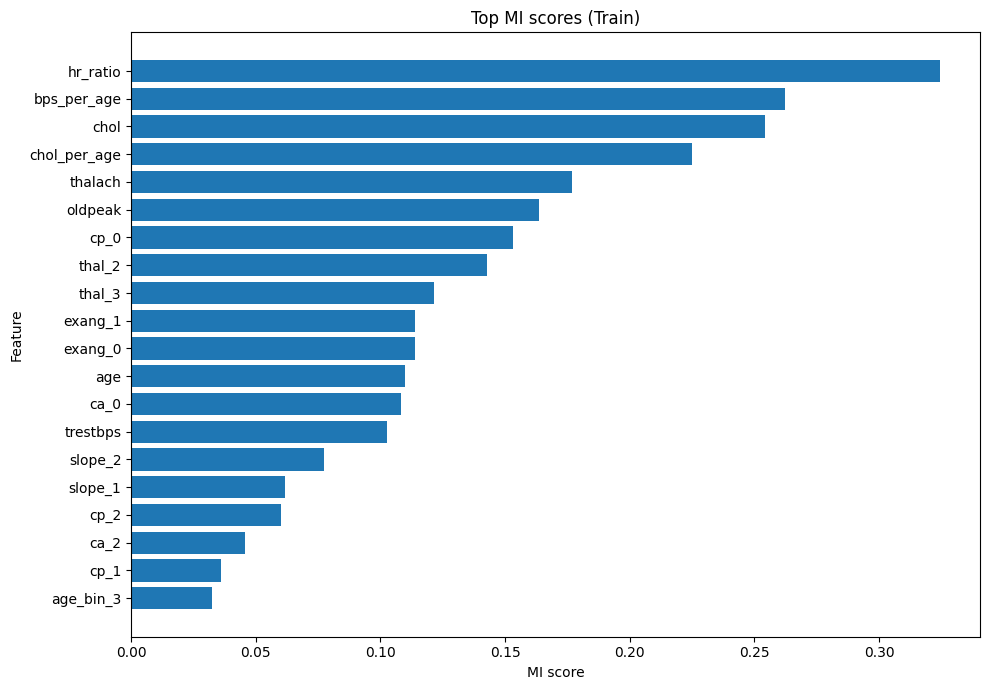

,fe_topk_features
0,hr_ratio
1,bps_per_age
2,chol
3,chol_per_age
4,thalach
5,oldpeak
6,cp_0
7,thal_2
8,thal_3
9,exang_1


In [18]:
ohe = fe_pre.named_steps['pre'].named_transformers_['cat'].named_steps['ohe']
cat_names = list(ohe.get_feature_names_out(all_cats))
is_discrete = np.array(
    [c in cat_names for c in Xt_tr.columns],
    dtype=bool
)
mi = mutual_info_classif(Xt_tr.values, y_train.values,
                         discrete_features=is_discrete,
                         random_state=42)
mi_series = pd.Series(
    mi, index=Xt_tr.columns).sort_values(ascending=False)

N = min(20, len(mi_series))
topN = mi_series.head(N).iloc[::-1]
plt.figure(figsize=(10, max(6, 0.35*N)))
plt.barh(topN.index, topN.values)
plt.title('Top MI scores (Train)')
plt.xlabel('MI score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('top_mi_scores.pdf', bbox_inches='tight')
plt.show()

K = raw.columns.drop('target').shape[0]
topk_cols = list(mi_series.head(K).index)

fe_tr = Xt_tr[topk_cols].assign(target=y_train.values)
fe_va = Xt_va[topk_cols].assign(target=y_val.values)
fe_te = Xt_te[topk_cols].assign(target=y_test.values)

out = Path('splits'); out.mkdir(parents=True, exist_ok=True)
fe_tr.to_csv(out/'fe_train.csv', index=False)
fe_va.to_csv(out/'fe_val.csv', index=False)
fe_te.to_csv(out/'fe_test.csv', index=False)

display(pd.Series(
    topk_cols, name='fe_topk_features'
).reset_index(drop=True))

In [19]:
display(fe_tr.head())

,hr_ratio,bps_per_age,chol,chol_per_age,thalach,oldpeak,cp_0,thal_2,thal_3,exang_1,exang_0,age,ca_0,target
4,-1.374287,-0.534219,0.895791,0.091215,-1.921155,0.696525,1.0,1.0,0.0,0.0,1.0,0.811626,0.0,0
688,-0.573652,2.272794,0.779115,0.454742,-0.725362,2.475810,1.0,0.0,1.0,1.0,0.0,0.152247,0.0,0
477,-0.264890,-0.492900,-0.368191,-0.565612,0.027545,-0.574393,0.0,0.0,1.0,0.0,1.0,0.262144,0.0,0
336,0.220684,0.312236,-2.371116,-2.204087,1.046184,-0.743849,0.0,0.0,1.0,0.0,1.0,0.262144,0.0,1
960,0.479305,0.278454,-1.009905,-0.790764,0.869030,-0.828577,0.0,1.0,0.0,0.0,1.0,-0.287339,1.0,1


##8.Decision Tree on Feature Engineering Dataset

In [20]:
dt_fe_feature_selection_pipeline = Pipeline([
    # 1) Feature engineering + preprocessing (đã định nghĩa ở trên)
    ('fe_pre', fe_pre),

    # 2) Chọn đặc trưng theo độ quan trọng của DecisionTree (top-K)
    ('feature_select', SelectFromModel(
        estimator=DecisionTreeClassifier(
            random_state=42,
            class_weight='balanced'
        ),
        max_features=K_features,
        threshold=None  # chọn đúng top-K theo feature_importances_
    ))
])

In [21]:
# Huấn luyện toàn pipeline
dt_fe_feature_selection_pipeline.fit(
    X_train, y_train
)

# Lấy tên cột sau bước fe_pre
pipeline_feature_names = dt_fe_feature_selection_pipeline.named_steps['fe_pre'] \
    .named_steps['pre'].get_feature_names_out()

# Lấy importance từ DecisionTree đã fit bên trong SelectFromModel
feature_importance_series = pd.Series(
    dt_fe_feature_selection_pipeline.named_steps['feature_select']
    .estimator_.feature_importances_,
    index=pipeline_feature_names
)

sorted_feature_importances = feature_importance_series.sort_values(ascending=False)
print("Sorted Feature Importances:")
display(sorted_feature_importances)

Sorted Feature Importances:


,0
cp_0,2.901826e-01
chol_per_age,9.527445e-02
age,8.890052e-02
oldpeak,8.663352e-02
thal_2,8.468043e-02
ca_0,7.904504e-02
bps_per_age,5.713169e-02
chol,4.750879e-02
sex_0,4.032575e-02
thalach,3.612983e-02


In [22]:
selected_features = np.array(pipeline_feature_names)[
    dt_fe_feature_selection_pipeline.named_steps['feature_select'].get_support()
]

print(f"Top {K_features} selected features:")
print(selected_features)

Top 10 selected features:
['age' 'chol' 'thalach' 'oldpeak' 'chol_per_age' 'bps_per_age' 'sex_0'
 'cp_0' 'ca_0' 'thal_2']


In [23]:
X_fe_dt_train = pd.DataFrame(
    dt_fe_feature_selection_pipeline.transform(X_train),
    columns=selected_features,
    index=X_train.index
)

X_fe_dt_val = pd.DataFrame(
    dt_fe_feature_selection_pipeline.transform(X_val),
    columns=selected_features,
    index=X_val.index
)

X_fe_dt_test = pd.DataFrame(
    dt_fe_feature_selection_pipeline.transform(X_test),
    columns=selected_features,
    index=X_test.index
)

print("Head of X_fe_dt_train:")
display(X_fe_dt_train.head())
print("\nShape of X_fe_dt_train:", X_fe_dt_train.shape)

Head of X_fe_dt_train:


,age,chol,thalach,oldpeak,chol_per_age,bps_per_age,sex_0,cp_0,ca_0,thal_2
4,0.811626,0.895791,-1.921155,0.696525,0.091215,-0.534219,1.0,1.0,0.0,1.0
688,0.152247,0.779115,-0.725362,2.475810,0.454742,2.272794,1.0,1.0,0.0,0.0
477,0.262144,-0.368191,0.027545,-0.574393,-0.565612,-0.492900,0.0,0.0,0.0,0.0
336,0.262144,-2.371116,1.046184,-0.743849,-2.204087,0.312236,0.0,0.0,0.0,0.0
960,-0.287339,-1.009905,0.869030,-0.828577,-0.790764,0.278454,1.0,0.0,1.0,1.0



Shape of X_fe_dt_train: (820, 10)


In [24]:
pd.concat([X_fe_dt_train, y_train.rename(TARGET)],
          axis=1).to_csv(out_dir / 'fe_dt_train.csv', index=False)
pd.concat([X_fe_dt_val, y_val.rename(TARGET)],
          axis=1).to_csv(out_dir / 'fe_dt_val.csv', index=False)
pd.concat([X_fe_dt_test, y_test.rename(TARGET)],
          axis=1).to_csv(out_dir / 'fe_dt_test.csv', index=False)

print(f"Saved FE_DT splits. K (FE features) = {K_features}")

Saved FE_DT splits. K (FE features) = 10


In [ ]:
X_fe_dt_train

,age,chol,thalach,oldpeak,chol_per_age,bps_per_age,sex_0,cp_0,ca_0,thal_2
4,0.811626,0.895791,-1.921155,0.696525,0.091215,-0.534219,1.0,1.0,0.0,1.0
688,0.152247,0.779115,-0.725362,2.475810,0.454742,2.272794,1.0,1.0,0.0,0.0
477,0.262144,-0.368191,0.027545,-0.574393,-0.565612,-0.492900,0.0,0.0,0.0,0.0
336,0.262144,-2.371116,1.046184,-0.743849,-2.204087,0.312236,0.0,0.0,0.0,0.0
960,-0.287339,-1.009905,0.869030,-0.828577,-0.790764,0.278454,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
882,0.262144,-2.273886,-1.522557,0.103430,-2.124549,-0.419706,0.0,1.0,0.0,0.0
367,-0.726926,-0.368191,0.824741,-0.066026,0.117418,-0.396832,0.0,0.0,1.0,0.0
393,0.811626,-1.632172,-0.193898,4.339823,-1.809991,0.205987,1.0,1.0,0.0,0.0
777,-0.177443,0.662440,-2.408330,0.781253,0.616047,-0.336154,0.0,1.0,0.0,0.0


In [25]:
# zip folder
!zip -r dataset.zip splits

  adding: splits/ (stored 0%)
  adding: splits/fe_dt_train.csv (deflated 82%)
  adding: splits/raw_val.csv (deflated 78%)
  adding: splits/fe_test.csv (deflated 67%)
  adding: splits/dt_train.csv (deflated 90%)
  adding: splits/fe_val.csv (deflated 69%)
  adding: splits/dt_test.csv (deflated 76%)
  adding: splits/raw_test.csv (deflated 77%)
  adding: splits/fe_dt_val.csv (deflated 69%)
  adding: splits/raw_train.csv (deflated 88%)
  adding: splits/dt_val.csv (deflated 77%)
  adding: splits/fe_dt_test.csv (deflated 68%)
  adding: splits/fe_train.csv (deflated 80%)


# 9.Huấn luyện mô hình

## 9.1 Random Forest Approach

In [26]:
param_dist = {
    "n_estimators": randint(100, 1200),
    "max_depth": [None] + list(range(3, 21, 3)),
    "min_samples_split": randint(2, 11),
    "min_samples_leaf": randint(1, 6),
    "max_features": ["sqrt", "log2", None],
    "bootstrap": [True],
    "class_weight": [None, "balanced"],
}

rs = RandomizedSearchCV(
    RandomForestClassifier(random_state=SEED, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=60, scoring="roc_auc", cv=skf, n_jobs=-1, random_state=SEED, verbose=1
)

In [27]:
rs.fit(Xt_tr, y_train)
best_rf = rs.best_estimator_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


In [28]:
print("Best params (CV):", rs.best_params_)
print("Best CV ROC AUC:", rs.best_score_)

Best params (CV): {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 18, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1176}
Best CV ROC AUC: 0.99875


In [29]:
# Đánh giá trên validation
p_val = best_rf.predict_proba(Xt_va)[:, 1]
print("Val ROC AUC:", roc_auc_score(y_val, p_val))
print("Val Accuracy:", accuracy_score(y_val, best_rf.predict(Xt_va)))
print("Val report:\n", classification_report(y_val, (p_val>=0.5).astype(int), digits=3))

# (Tuỳ chọn) Train lại trên train+val rồi đánh giá test
X_tv = pd.concat([Xt_tr, Xt_va], axis=0)
y_tv = pd.concat([y_train, y_val], axis=0)
best_rf.fit(X_tv, y_tv)

p_test = best_rf.predict_proba(Xt_te)[:, 1]
print("Test ROC AUC:", roc_auc_score(y_test, p_test))
print("Test Accuracy:", accuracy_score(y_test, (p_test>=0.5).astype(int)))
print("Test report:\n", classification_report(y_test, (p_test>=0.5).astype(int), digits=3))

Val ROC AUC: 1.0
Val Accuracy: 1.0
Val report:
               precision    recall  f1-score   support

           0      1.000     1.000     1.000        50
           1      1.000     1.000     1.000        52

    accuracy                          1.000       102
   macro avg      1.000     1.000     1.000       102
weighted avg      1.000     1.000     1.000       102

Test ROC AUC: 1.0
Test Accuracy: 1.0
Test report:
               precision    recall  f1-score   support

           0      1.000     1.000     1.000        50
           1      1.000     1.000     1.000        53

    accuracy                          1.000       103
   macro avg      1.000     1.000     1.000       103
weighted avg      1.000     1.000     1.000       103



##9.2 AdaBoost Approach

In [30]:
def find_optimal_ada(
    X_train, y_train,
    base_max_depth=1,
    algorithm="SAMME",                # như trong hình
    n_estimators_range=range(50, 501, 50),
    cv_splits=3,
    learning_rate=0.1
):
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=SEED)
    scores = []

    for n in n_estimators_range:
        ada = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=base_max_depth, random_state=SEED),
            n_estimators=n,
            learning_rate=learning_rate,
            algorithm=algorithm,
            random_state=SEED
        )
        cv_score = cross_val_score(
            ada, X_train, y_train,
            cv=cv, scoring='accuracy', n_jobs=-1
        )
        scores.append(cv_score.mean())

    # Lấy n_estimators tối ưu
    best_n = list(n_estimators_range)[int(np.argmax(scores))]
    print(f"n_estimators tối ưu (CV): {best_n}")

    # Train lại với toàn bộ X_train
    best_model = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=base_max_depth, random_state=SEED),
        n_estimators=best_n,
        learning_rate=learning_rate,
        algorithm=algorithm,
        random_state=SEED
    )
    best_model.fit(X_train, y_train)
    return best_model, best_n, max(scores)
def evaluate_val_ada(
    X_train, y_train, X_val, y_val,
    n_estimators_range=range(50, 501, 50),
    cv_splits=3,
    learning_rate=0.1,
    base_max_depth=1,
    algorithm="SAMME"
):
    print("Tìm n_estimators tối ưu cho AdaBoost…")
    ada_model, best_n, cv_mean = find_optimal_ada(
        X_train, y_train,
        n_estimators_range=n_estimators_range,
        cv_splits=cv_splits,
        learning_rate=learning_rate,
        base_max_depth=base_max_depth,
        algorithm=algorithm
    )

    # Dự đoán & báo cáo trên validation
    val_pred = ada_model.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)
    print(f"\nĐộ chính xác AdaBoost trên tập validation: {val_acc:.4f}")
    print("Classification Report (val):")
    print(classification_report(y_val, val_pred, digits=3))

    best_params = {"n_estimators": best_n}
    return ada_model, val_acc, best_params


def evaluate_test_ada(ada_model, X_test, y_test):
    test_pred = ada_model.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    print(f"\nĐộ chính xác AdaBoost trên tập test: {test_acc:.4f}")
    print("Classification Report (test):")
    print(classification_report(y_test, test_pred, digits=3))
    return test_acc

In [31]:
ada_model, val_fe_acc, best_params = evaluate_val_ada(Xt_tr, y_train, Xt_va, y_val)
test_fe_acc = evaluate_test_ada(ada_model, Xt_te, y_test)

Tìm n_estimators tối ưu cho AdaBoost…
n_estimators tối ưu (CV): 350


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(



Độ chính xác AdaBoost trên tập validation: 0.8824
Classification Report (val):
              precision    recall  f1-score   support

           0      0.913     0.840     0.875        50
           1      0.857     0.923     0.889        52

    accuracy                          0.882       102
   macro avg      0.885     0.882     0.882       102
weighted avg      0.885     0.882     0.882       102


Độ chính xác AdaBoost trên tập test: 0.8835
Classification Report (test):
              precision    recall  f1-score   support

           0      0.880     0.880     0.880        50
           1      0.887     0.887     0.887        53

    accuracy                          0.883       103
   macro avg      0.883     0.883     0.883       103
weighted avg      0.883     0.883     0.883       103



In [32]:
ada_model, val_dt_acc, best_params = evaluate_val_ada(X_dt_train, y_train, X_dt_val, y_val)
test_dt_acc = evaluate_test_ada(ada_model, X_dt_test, y_test)

Tìm n_estimators tối ưu cho AdaBoost…
n_estimators tối ưu (CV): 450


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(



Độ chính xác AdaBoost trên tập validation: 0.8529
Classification Report (val):
              precision    recall  f1-score   support

           0      0.872     0.820     0.845        50
           1      0.836     0.885     0.860        52

    accuracy                          0.853       102
   macro avg      0.854     0.852     0.853       102
weighted avg      0.854     0.853     0.853       102


Độ chính xác AdaBoost trên tập test: 0.8350
Classification Report (test):
              precision    recall  f1-score   support

           0      0.824     0.840     0.832        50
           1      0.846     0.830     0.838        53

    accuracy                          0.835       103
   macro avg      0.835     0.835     0.835       103
weighted avg      0.835     0.835     0.835       103



In [33]:
ada_model, val_fe_dt_acc, best_params = evaluate_val_ada(X_fe_dt_train, y_train, X_fe_dt_val, y_val)
test_fe_dt_acc = evaluate_test_ada(ada_model, X_fe_dt_test, y_test)


Tìm n_estimators tối ưu cho AdaBoost…
n_estimators tối ưu (CV): 450


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(



Độ chính xác AdaBoost trên tập validation: 0.8725
Classification Report (val):
              precision    recall  f1-score   support

           0      0.894     0.840     0.866        50
           1      0.855     0.904     0.879        52

    accuracy                          0.873       102
   macro avg      0.874     0.872     0.872       102
weighted avg      0.874     0.873     0.872       102


Độ chính xác AdaBoost trên tập test: 0.8544
Classification Report (test):
              precision    recall  f1-score   support

           0      0.857     0.840     0.848        50
           1      0.852     0.868     0.860        53

    accuracy                          0.854       103
   macro avg      0.854     0.854     0.854       103
weighted avg      0.854     0.854     0.854       103



## 9.3 KNN, K-Means, Decision tree, XGBoost, LightGBM, tuyến tính, SVM

In [34]:
# (tuỳ chọn) dùng X_train nếu bạn không có Xt_*
XTR, XVA, XTE = Xt_tr, Xt_va, Xt_te
yTR, yVA, yTE = y_train, y_val, y_test

def _probas_or_scores(est, X):
    """Trả về xác suất lớp 1 nếu có, nếu không dùng decision_function rồi chuẩn hoá 0..1."""
    if hasattr(est, "predict_proba"):
        return est.predict_proba(X)[:, 1]
    if hasattr(est, "decision_function"):
        s = est.decision_function(X).astype(float)
        # min-max scale để dùng cho ROC AUC an toàn
        s = (s - s.min()) / (s.max() - s.min() + 1e-12)
        return s
    # fallback: 0/1
    return est.predict(X).astype(float)

def evaluate_best(model, X_val, y_val, X_test, y_test, name="model"):
    p_val  = _probas_or_scores(model, X_val)
    p_test = _probas_or_scores(model, X_test)
    print(f"\n{name} — Validation:")
    print(" ROC AUC:", roc_auc_score(y_val, p_val))
    print(" Accuracy:", accuracy_score(y_val, (p_val >= 0.5).astype(int)))
    print(" Report (val):\n", classification_report(y_val, (p_val >= 0.5).astype(int), digits=3))
    print(f"{name} — Test:")
    print(" ROC AUC:", roc_auc_score(y_test, p_test))
    print(" Accuracy:", accuracy_score(y_test, (p_test >= 0.5).astype(int)))
    print(" Report (test):\n", classification_report(y_test, (p_test >= 0.5).astype(int), digits=3))


In [35]:
#KNN
knn = KNeighborsClassifier()
knn_grid = {
    "n_neighbors": [3,5,7,9,11,15,21],
    "weights": ["uniform", "distance"],
    "p": [1, 2]  # 1=Manhattan, 2=Euclidean
}
knn_gs = GridSearchCV(knn, param_grid=knn_grid, scoring="roc_auc", cv=skf, n_jobs=-1, refit=True, verbose=0)
knn_gs.fit(XTR, yTR)
knn_best = knn_gs.best_estimator_
print("KNN best params:", knn_gs.best_params_, "CV ROC AUC:", knn_gs.best_score_)
evaluate_best(knn_best, XVA, yVA, XTE, yTE, name="KNN")

KNN best params: {'n_neighbors': 11, 'p': 1, 'weights': 'distance'} CV ROC AUC: 0.9994940476190475

KNN — Validation:
 ROC AUC: 1.0
 Accuracy: 0.9803921568627451
 Report (val):
               precision    recall  f1-score   support

           0      0.962     1.000     0.980        50
           1      1.000     0.962     0.980        52

    accuracy                          0.980       102
   macro avg      0.981     0.981     0.980       102
weighted avg      0.981     0.980     0.980       102

KNN — Test:
 ROC AUC: 0.999622641509434
 Accuracy: 0.9805825242718447
 Report (test):
               precision    recall  f1-score   support

           0      0.980     0.980     0.980        50
           1      0.981     0.981     0.981        53

    accuracy                          0.981       103
   macro avg      0.981     0.981     0.981       103
weighted avg      0.981     0.981     0.981       103



In [36]:
dt = DecisionTreeClassifier(random_state=SEED)
dt_grid = {
    "max_depth": [None, 3,5,7,9,12,15],
    "min_samples_split": [2,5,10,20],
    "min_samples_leaf": [1,2,4,8],
    "class_weight": [None, "balanced"]
}
dt_gs = GridSearchCV(dt, param_grid=dt_grid, scoring="roc_auc", cv=skf, n_jobs=-1, refit=True, verbose=0)
dt_gs.fit(XTR, yTR)
dt_best = dt_gs.best_estimator_
print("DT best params:", dt_gs.best_params_, "CV ROC AUC:", dt_gs.best_score_)
evaluate_best(dt_best, XVA, yVA, XTE, yTE, name="DecisionTree")

DT best params: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5} CV ROC AUC: 0.9861747198879552

DecisionTree — Validation:
 ROC AUC: 0.9807692307692308
 Accuracy: 0.9705882352941176
 Report (val):
               precision    recall  f1-score   support

           0      0.943     1.000     0.971        50
           1      1.000     0.942     0.970        52

    accuracy                          0.971       102
   macro avg      0.972     0.971     0.971       102
weighted avg      0.972     0.971     0.971       102

DecisionTree — Test:
 ROC AUC: 0.99
 Accuracy: 0.970873786407767
 Report (test):
               precision    recall  f1-score   support

           0      0.943     1.000     0.971        50
           1      1.000     0.943     0.971        53

    accuracy                          0.971       103
   macro avg      0.972     0.972     0.971       103
weighted avg      0.973     0.971     0.971       103



In [37]:
logreg = LogisticRegression(max_iter=2000, solver="liblinear")
log_grid = {
    "C": np.logspace(-3, 3, 9),
    "class_weight": [None, "balanced"],
    "penalty": ["l1", "l2"]
}
log_gs = GridSearchCV(logreg, param_grid=log_grid, scoring="roc_auc", cv=skf, n_jobs=-1, refit=True, verbose=0)
log_gs.fit(XTR, yTR)
log_best = log_gs.best_estimator_
print("LogReg best params:", log_gs.best_params_, "CV ROC AUC:", log_gs.best_score_)
evaluate_best(log_best, XVA, yVA, XTE, yTE, name="LogisticRegression")

LogReg best params: {'C': np.float64(31.622776601683793), 'class_weight': None, 'penalty': 'l2'} CV ROC AUC: 0.9419248395560755

LogisticRegression — Validation:
 ROC AUC: 0.9530769230769232
 Accuracy: 0.9019607843137255
 Report (val):
               precision    recall  f1-score   support

           0      0.885     0.920     0.902        50
           1      0.920     0.885     0.902        52

    accuracy                          0.902       102
   macro avg      0.902     0.902     0.902       102
weighted avg      0.903     0.902     0.902       102

LogisticRegression — Test:
 ROC AUC: 0.9286792452830189
 Accuracy: 0.883495145631068
 Report (test):
               precision    recall  f1-score   support

           0      0.932     0.820     0.872        50
           1      0.847     0.943     0.893        53

    accuracy                          0.883       103
   macro avg      0.890     0.882     0.883       103
weighted avg      0.888     0.883     0.883       103



In [38]:
#SVM (RBF)
svm = SVC(kernel="rbf", probability=True, random_state=SEED)
svm_grid = {
    "C": np.logspace(-2, 3, 10),
    "gamma": np.logspace(-4, 1, 6),
    "class_weight": [None, "balanced"]
}
svm_gs = GridSearchCV(svm, param_grid=svm_grid, scoring="roc_auc", cv=skf, n_jobs=-1, refit=True, verbose=0)
svm_gs.fit(XTR, yTR)
svm_best = svm_gs.best_estimator_
print("SVM best params:", svm_gs.best_params_, "CV ROC AUC:", svm_gs.best_score_)
evaluate_best(svm_best, XVA, yVA, XTE, yTE, name="SVM (RBF)")

SVM best params: {'C': np.float64(0.03593813663804628), 'class_weight': None, 'gamma': np.float64(1.0)} CV ROC AUC: 0.9981845238095237

SVM (RBF) — Validation:
 ROC AUC: 1.0
 Accuracy: 0.9803921568627451
 Report (val):
               precision    recall  f1-score   support

           0      0.962     1.000     0.980        50
           1      1.000     0.962     0.980        52

    accuracy                          0.980       102
   macro avg      0.981     0.981     0.980       102
weighted avg      0.981     0.980     0.980       102

SVM (RBF) — Test:
 ROC AUC: 1.0
 Accuracy: 0.9902912621359223
 Report (test):
               precision    recall  f1-score   support

           0      0.980     1.000     0.990        50
           1      1.000     0.981     0.990        53

    accuracy                          0.990       103
   macro avg      0.990     0.991     0.990       103
weighted avg      0.990     0.990     0.990       103



In [39]:
#XGBoost
try:
    from xgboost import XGBClassifier
    xgb = XGBClassifier(
        random_state=SEED, n_jobs=-1, eval_metric="logloss",
        tree_method="hist", use_label_encoder=False
    )
    xgb_dist = {
        "n_estimators": randint(200, 1000),
        "max_depth": randint(3, 9),
        "learning_rate": uniform(0.01, 0.2),
        "subsample": uniform(0.6, 0.4),
        "colsample_bytree": uniform(0.6, 0.4),
        "gamma": uniform(0.0, 0.4)
    }
    xgb_rs = RandomizedSearchCV(xgb, param_distributions=xgb_dist, n_iter=50,
                                scoring="roc_auc", cv=skf, n_jobs=-1, random_state=SEED, refit=True, verbose=0)
    xgb_rs.fit(XTR, yTR)
    xgb_best = xgb_rs.best_estimator_
    print("XGB best params:", xgb_rs.best_params_, "CV ROC AUC:", xgb_rs.best_score_)
    evaluate_best(xgb_best, XVA, yVA, XTE, yTE, name="XGBoost")
except Exception as e:
    print("⚠️ XGBoost chưa cài hoặc lỗi import. Cài: pip install xgboost\n", e)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [02:58:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGB best params: {'colsample_bytree': np.float64(0.7599443886861021), 'gamma': np.float64(0.01866626528544617), 'learning_rate': np.float64(0.20475110376829186), 'max_depth': 8, 'n_estimators': 886, 'subsample': np.float64(0.8473544037332349)} CV ROC AUC: 0.9962795846186575

XGBoost — Validation:
 ROC AUC: 1.0
 Accuracy: 1.0
 Report (val):
               precision    recall  f1-score   support

           0      1.000     1.000     1.000        50
           1      1.000     1.000     1.000        52

    accuracy                          1.000       102
   macro avg      1.000     1.000     1.000       102
weighted avg      1.000     1.000     1.000       102

XGBoost — Test:
 ROC AUC: 1.0
 Accuracy: 1.0
 Report (test):
               precision    recall  f1-score   support

           0      1.000     1.000     1.000        50
           1      1.000     1.000     1.000        53

    accuracy                          1.000       103
   macro avg      1.000     1.000     1.000       

In [40]:
#LightGBM
try:
    from lightgbm import LGBMClassifier
    lgbm = LGBMClassifier(random_state=SEED)
    lgbm_dist = {
        "n_estimators": randint(200, 1000),
        "learning_rate": uniform(0.01, 0.2),
        "max_depth": randint(-1, 10),       # -1 = no limit
        "num_leaves": randint(16, 64),
        "subsample": uniform(0.6, 0.4),
        "colsample_bytree": uniform(0.6, 0.4)
    }
    lgbm_rs = RandomizedSearchCV(lgbm, param_distributions=lgbm_dist, n_iter=50,
                                 scoring="roc_auc", cv=skf, n_jobs=-1, random_state=SEED, refit=True, verbose=0)
    lgbm_rs.fit(XTR, yTR)
    lgbm_best = lgbm_rs.best_estimator_
    print("LGBM best params:", lgbm_rs.best_params_, "CV ROC AUC:", lgbm_rs.best_score_)
    evaluate_best(lgbm_best, XVA, yVA, XTE, yTE, name="LightGBM")
except Exception as e:
    print("⚠️ LightGBM chưa cài hoặc lỗi import. Cài: pip install lightgbm\n", e)


[LightGBM] [Info] Number of positive: 421, number of negative: 399
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 820, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.513415 -> initscore=0.053671
[LightGBM] [Info] Start training from score 0.053671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [41]:
#K-Means (unsupervised)
# Chọn k theo silhouette trên tập train, rồi đánh giá tạm thời bằng "gán nhãn theo majority" trên val/test để tham khảo
from sklearn.metrics import silhouette_score
best_k, best_sil = None, -1
for k in range(2, 11):
    km = KMeans(n_clusters=k, n_init=20, random_state=SEED)
    lab = km.fit_predict(XTR)
    sil = silhouette_score(XTR, lab)
    if sil > best_sil:
        best_sil, best_k = sil, k
print(f"\nKMeans — best k (silhouette on train): {best_k} (score={best_sil:.3f})")

km_best = KMeans(n_clusters=best_k, n_init=20, random_state=SEED).fit(XTR)

def majority_vote_predict(km, X_ref, y_ref, X_new):
    # ánh xạ mỗi cluster -> nhãn majority dựa trên (X_ref, y_ref)
    cl_ref = km.predict(X_ref)
    mapping = {}
    for c in np.unique(cl_ref):
        ys = y_ref[cl_ref == c]
        mapping[c] = int(np.round(ys.mean()))  # hoặc majority class
    return np.array([mapping[c] for c in km.predict(X_new)])


KMeans — best k (silhouette on train): 2 (score=0.181)


In [42]:
y_val_km = majority_vote_predict(km_best, XTR, yTR.values, XVA)
y_test_km = majority_vote_predict(km_best, XTR, yTR.values, XTE)
print("\nKMeans — Validation Accuracy (majority-vote proxy):", accuracy_score(yVA, y_val_km))
print("KMeans — Test Accuracy (majority-vote proxy):", accuracy_score(yTE, y_test_km))


KMeans — Validation Accuracy (majority-vote proxy): 0.6764705882352942
KMeans — Test Accuracy (majority-vote proxy): 0.6310679611650486


##9.4 Gradient Boosting Approach

In [43]:
# ---- Tuning + fit trên tập train; trả về model tốt nhất ----
def evaluate_val_gb(
    X_train, y_train, X_val, y_val,
    n_iter=60, cv=skf
):
    gb = GradientBoostingClassifier(random_state=SEED)

    param_dist = {
        "n_estimators": randint(100, 800),
        "learning_rate": uniform(0.01, 0.29),  # ~0.01..0.30
        "max_depth": randint(2, 6),            # độ sâu cây con (weak learner)
        "subsample": uniform(0.6, 0.4),        # 0.6..1.0 (stochastic GB)
        "min_samples_split": randint(2, 11),
        "min_samples_leaf": randint(1, 6),
        "max_features": ["sqrt", "log2", None],
    }

    rs = RandomizedSearchCV(
        estimator=gb,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1,
        random_state=SEED,
        refit=True,
        verbose=1
    )
    rs.fit(X_train, y_train)

    best_gb = rs.best_estimator_
    print("Best params (CV):", rs.best_params_)
    print("Best CV ROC AUC :", rs.best_score_)

    # Đánh giá trên validation
    p_val = best_gb.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, p_val)
    val_acc = accuracy_score(y_val, (p_val >= 0.5).astype(int))
    print(f"\nGradientBoosting — Validation")
    print(" ROC AUC :", val_auc)
    print(" Accuracy:", val_acc)
    print(" Report (val):\n", classification_report(y_val, (p_val >= 0.5).astype(int), digits=3))

    return best_gb, val_auc, val_acc, rs.best_params_

# ---- Đánh giá trên test ----
def evaluate_test_gb(gb_model, X_test, y_test):
    p_test = gb_model.predict_proba(X_test)[:, 1]
    test_auc = roc_auc_score(y_test, p_test)
    test_acc = accuracy_score(y_test, (p_test >= 0.5).astype(int))
    print(f"\nGradientBoosting — Test")
    print(" ROC AUC :", test_auc)
    print(" Accuracy:", test_acc)
    print(" Report (test):\n", classification_report(y_test, (p_test >= 0.5).astype(int), digits=3))
    return test_auc, test_acc

In [ ]:
gb_model_fe, val_auc_fe, val_acc_fe, gb_params_fe = evaluate_val_gb(Xt_tr, y_train, Xt_va, y_val)
test_auc_fe, test_acc_fe = evaluate_test_gb(gb_model_fe, Xt_te, y_test)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


In [ ]:
gb_model_dt, val_auc_dt, val_acc_dt, gb_params_dt = evaluate_val_gb(X_dt_train, y_train, X_dt_val, y_val)
test_auc_dt, test_acc_dt = evaluate_test_gb(gb_model_dt, X_dt_test, y_test)


In [ ]:
gb_model_fe_dt, val_auc_fe_dt, val_acc_fe_dt, gb_params_fe_dt = evaluate_val_gb(X_fe_dt_train, y_train, X_fe_dt_val, y_val)
test_auc_fe_dt, test_acc_fe_dt = evaluate_test_gb(gb_model_fe_dt, X_fe_dt_test, y_test)


Fitting 5 folds for each of 60 candidates, totalling 300 fits


# 10.Kết luận

In [ ]:
#1) Đăng ký các bộ dữ liệu (val/test)
dataset_order = ["Origin", "FE", "Origin+DT", "FE+DT"]

datasets = {}
if "X_raw_val_df" in globals() and "X_raw_test_df" in globals():
    datasets["Origin"] = {"val": (X_raw_val_df, y_val), "test": (X_raw_test_df, y_test)}
if "Xt_va" in globals() and "Xt_te" in globals():
    datasets["FE"] = {"val": (Xt_va, y_val), "test": (Xt_te, y_test)}
if "X_dt_val" in globals() and "X_dt_test" in globals():
    datasets["Origin+DT"] = {"val": (X_dt_val, y_val), "test": (X_dt_test, y_test)}
if "X_fe_dt_val" in globals() and "X_fe_dt_test" in globals():
    datasets["FE+DT"] = {"val": (X_fe_dt_val, y_val), "test": (X_fe_dt_test, y_test)}

present_cols = [k for k in dataset_order if k in datasets]
if not present_cols:
    raise RuntimeError("Không tìm thấy bộ dữ liệu val/test nào (Origin/FE/Origin+DT/FE+DT).")

# (tuỳ chọn) train sets cho KMeans proxy
train_sets = {}
if "X_raw_train_df" in globals(): train_sets["Origin"] = (X_raw_train_df, y_train)
if "Xt_tr" in globals():          train_sets["FE"]     = (Xt_tr, y_train)
if "X_dt_train" in globals():     train_sets["Origin+DT"] = (X_dt_train, y_train)
if "X_fe_dt_train" in globals():  train_sets["FE+DT"]  = (X_fe_dt_train, y_train)

#2) Gom model đã fit
models = {}
for name, var in [
    ("KNN", "knn_best"),
    ("Decision Tree", "dt_best"),
    ("Logistic Regression", "log_best"),
    ("SVM (RBF)", "svm_best"),
    ("Random Forest", "best_rf"),
    ("AdaBoost", "ada_model"),
    ("XGBoost", "xgb_best"),
    ("LightGBM", "lgbm_best"),
    ("KMeans (proxy acc)", "km_best"),
    ("Gradient Boosting (FE)", "gb_model_fe"),
    ("Gradient Boosting (DT)", "gb_model_dt"),
    ("Gradient Boosting (FE+DT)", "gb_model_fe_dt"),
    ("Gradient Boosting", "gb_model"),
    ("Gradient Boosting", "gb_best"),
    ("Gradient Boosting", "gbc_best"),
    ("XGBoost", "xgb_best"),
    ("LightGBM", "lgbm_best"),
    ("KMeans (proxy acc)", "km_best"),
]:
    if var in globals():
        models[name] = globals()[var]
if not models:
    raise RuntimeError("Chưa có mô hình nào (ví dụ: best_rf, log_best...). Hãy train trước.")

#3) Helpers
def is_compatible(model, X: pd.DataFrame) -> bool:
    """True nếu X có cùng thứ tự & tên cột như lúc model.fit()"""
    fin = getattr(model, "feature_names_in_", None)
    if fin is None:
        # một số estimator (xgb/lgbm/old sklearn) không có feature_names_in_
        try:
            _ = model.predict(X.iloc[:1])
            return True
        except Exception:
            return False
    return list(fin) == list(X.columns)

def _scores_safe(est, X):
    if hasattr(est, "predict_proba"):
        return est.predict_proba(X)[:, 1]
    if hasattr(est, "decision_function"):
        s = est.decision_function(X).astype(float)
        return (s - s.min()) / (s.max() - s.min() + 1e-12)
    return est.predict(X).astype(float)

def _kmeans_proxy_acc_safe(km, space, split="val"):
    if space not in datasets or space not in train_sets:
        return np.nan
    X_ref, y_ref = train_sets[space]
    X_eval, y_eval = datasets[space][split]
    if not (is_compatible(km, X_ref) and is_compatible(km, X_eval)):
        return np.nan
    cl_ref = km.predict(X_ref)
    mapping = {}
    for c in np.unique(cl_ref):
        ys = np.asarray(y_ref)[cl_ref == c]
        mapping[c] = int(np.round(ys.mean()))
    y_pred = np.array([mapping[c] for c in km.predict(X_eval)])
    return accuracy_score(y_eval, y_pred)

#4) Tạo bảng kết quả (có kiểm tra tương thích cột)
splits = ["Val", "Test"]
cols = pd.MultiIndex.from_product([splits, present_cols])
table = pd.DataFrame(index=list(models.keys()), columns=cols, dtype=float)

for model_name, model in models.items():
    for space in present_cols:
        if model_name.startswith("KMeans"):
            table.loc[model_name, ("Val", space)]  = _kmeans_proxy_acc_safe(model, space, "val")
            table.loc[model_name, ("Test", space)] = _kmeans_proxy_acc_safe(model, space, "test")
            continue

        Xv, yv = datasets[space]["val"]
        Xt, yt = datasets[space]["test"]

        if not (is_compatible(model, Xv) and is_compatible(model, Xt)):
            table.loc[model_name, ("Val", space)]  = np.nan
            table.loc[model_name, ("Test", space)] = np.nan
            continue

        try:
            p_val  = _scores_safe(model, Xv)
            p_test = _scores_safe(model, Xt)
            table.loc[model_name, ("Val", space)]  = accuracy_score(yv, (p_val  >= 0.5).astype(int))
            table.loc[model_name, ("Test", space)] = accuracy_score(yt, (p_test >= 0.5).astype(int))
        except Exception:
            table.loc[model_name, ("Val", space)]  = np.nan
            table.loc[model_name, ("Test", space)] = np.nan

# Hiển thị bảng như mẫu (.90 dạng .xx)
def _fmt_cell(v):
    if pd.isna(v):
        return ""
    s = f"{v:.2f}"
    return s[1:] if float(v) < 1 else s  # hiển thị .90 như mẫu

styled = (table.copy()
          .style
          .format(_fmt_cell)
          .set_table_styles([
              {"selector": "table", "props": [("border-collapse", "collapse"),
                                              ("border", "1px solid #666")]},
              {"selector": "th",    "props": [("border", "1px solid #666"),
                                              ("padding", "6px"),
                                              ("text-align", "center")]},
              {"selector": "td",    "props": [("border", "1px solid #666"),
                                              ("padding", "6px"),
                                              ("text-align", "center")]},
          ])
)

# (tuỳ chọn) đường kẻ dọc đậm giữa nhóm header cấp 0 (Val/Test)
styled = styled.set_table_styles(
    [{"selector": "th.col_heading.level0", "props": [("border-right", "2px solid #333")]}],
    overwrite=False
)

display(styled)


#5) Vẽ heatmap
def plot_heatmap(mat, title):
    plt.figure(figsize=(1.8*len(present_cols)+3, 0.6*len(mat.index)+2))
    sns.heatmap(mat.astype(float), annot=True, fmt=".2f",
                cmap="Blues", vmin=0.5, vmax=1.0, cbar_kws={"shrink": .8})
    plt.title(title)
    plt.ylabel("Model")
    plt.xlabel("Feature Space")
    plt.tight_layout()
    plt.show()

val_mat = table["Val"]
if not val_mat.dropna(how="all").empty:
    plot_heatmap(val_mat, "Validation Accuracy by Feature Space")

test_mat = table["Test"]
if not test_mat.dropna(how="all").empty:
    plot_heatmap(test_mat, "Test Accuracy by Feature Space")

#6) Kết luận mô hình tốt nhất
# (fix) định nghĩa spaces để dùng trong vòng lặp dưới
spaces = list(val_mat.columns)
stacked = []
for m in table.index:
    for sp in spaces:
        val_acc  = val_mat.loc[m, sp]
        test_acc = test_mat.loc[m, sp]
        if not (pd.isna(val_acc) and pd.isna(test_acc)):
            stacked.append({"Model": m, "Space": sp, "ValAcc": val_acc, "TestAcc": test_acc})
stacked_df = pd.DataFrame(stacked).dropna(subset=["ValAcc"])

if not stacked_df.empty:
    best_row = (stacked_df.sort_values(["ValAcc", "TestAcc"], ascending=False).iloc[0])
    print("=== KẾT LUẬN ===")
    print(f"Mô hình tốt nhất (theo Validation Accuracy): {best_row['Model']} @ {best_row['Space']}")
    print(f"  • Validation Accuracy: {best_row['ValAcc']:.3f}")
    print(f"  • Test Accuracy      : {best_row['TestAcc']:.3f}")
    print("\nTop-5 cấu hình (Model @ Space) theo ValAcc:")
    display(stacked_df.sort_values(["ValAcc", "TestAcc"], ascending=False).head(5))
else:
    print("Không có cấu hình nào hợp lệ để kết luận (toàn NaN).")

# (tuỳ chọn) lưu csv
table.to_csv("summary_table_by_space.csv")
print("✅ Đã lưu: summary_table_by_space.csv")